# MCMC demo

This demo shows how the Metropolis-Hastings algorithm 
with/without annealing can be used to sample from a 
mixture of 2 Gaussians if we can sample from a Gaussian 
proposal. 

You can play and see the effects of the proposal, the 
annealing and the cooling schedule. Try to define new 
proposals and target functions.

**Author: Ruben Martinez-Cantin**

In [0]:
import time
import numpy as np
import matplotlib.pylab as pl

First, we define the function that we want to sample from.

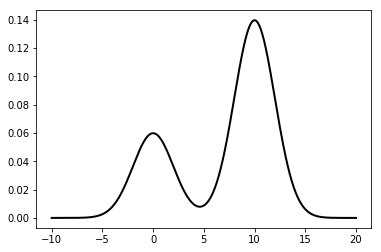

In [0]:
#Target distribution is a mixture of Gaussians.
def fgaussian(x,sigma):
    return np.exp(-0.5 * (x)**2 / sigma**2)/(np.sqrt(2*np.pi)*sigma)

def fmixture(x):
    sigma = 2      #  Standard deviation of the target components.
    return 0.3*fgaussian(x,sigma) + 0.7*fgaussian(x-10,sigma)

x_t = np.linspace(-10,20,1000)
pl.plot(x_t,fmixture(x_t),'k',linewidth=2)

Now, we define the _Metropolis-Hasting_ function to perform a step of the Markov chain. We also need to define the proposal.

In this case, we let the caller define an anealing temperature. Then, the step function generalizes to the _simulated anealing_ method.

In [0]:
# Metropolis-Hasting
###################################################################
# MH proposal is a zero mean Gaussian.
def sample_proposal(sigma):
    return sigma * np.random.randn(1)

def mh_step(x,sigma_prop,Temp=1.0):
    # We sample a move. This is the dynamics/Markov chain part.
    z = sample_proposal(sigma_prop)
    alpha1 = fmixture(x+z)  # Prob. of the sample after the move
    alpha2 = fmixture(x)    # Prob. of the sample before the move

    # This is the "likelihood" of the jump. If the probability of the new 
    # location is higher alpha > 1, if it is lower alpha < 1.
    alpha = (alpha1/alpha2)

    if Temp!=1.0:
        alpha = alpha**(1.0/Temp)      # Use annealing if required.
    
    # We randomize the acceptance. Sometimes we even have to accept unlikely events.
    u = np.random.rand(1)
    if (u < alpha):
        return x + z               # Accept jump
    else:
        return x                   # Reject jump

We do the same for the _slice sampling_ algorithm. In the slice sampling algorithm, we _cut_ the target function at a random height. Then, we combine a _step out_ and a _shrink_ phases to compute the width of the slice. Finally, the sample is generated from the width of the slice. 

In this case, the standard deviation of the proposal $\sigma$ is used as a step out coefficient. A large coefficient means a faster computation of the slice, but with lower resolution, requiring more time _shrinking_

In [0]:
# Slice sampling
###################################################################
def sweep(f,x,y,w):
    #step out
    r = np.random.rand(1)
    xl = x - r*w
    xr = x + (1-r)*w
    
    while f(xl)>y: xl -= w;
    while f(xr)>y: xr += w;

    #shrink
    modified = True
    while modified:
        x_new = (xr-xl) * np.random.rand(1) + xl
        if f(x_new) < y:
            if x_new > x:
                xr = x_new
            elif x_new < x:
                xl = x_new
            else:
                print("Error. Slice colapsed!")
                modified=False
        else:
            modified=False

    return x_new, xl, xr

def slice_step(x,sigma_prop):
    y_max = fmixture(x)
    u = np.random.rand(1)*y_max
    x_new,xl,xr = sweep(fmixture,x,u,sigma_prop)
    return x_new

Finally, we generate the MCMC trajectory based on the corresponding step functions. The _simulated annealing_ algorithm can be computed with a MH step function and a temperature.

In [0]:
# Main function
def mcmc(sampler,n_samples):
    sigma_prop = 10         #  Standard deviation of the Gaussian proposal.
    T_i = 1.0               #  Initial temperature (only used for annealing)
    CS = 0.995              #  Cooling schedule (only used for annealing)
    
    x = np.zeros((n_samples,1))  #  Markov chain (unknowns).
    x[0] = 20*np.random.rand(1)       #  Initial point of the Markov Chain.

    for i in range(1,n_samples):
        if sampler == 'mh':
            # Metropolis-Hastings algorithm
            x[i] = mh_step(x[i-1],sigma_prop)
        elif sampler == 'sa':
            # Simulated annealing algorithm. Version of MH for optimization.
            x[i] = mh_step(x[i-1],sigma_prop,T_i)
            T_i = T_i*CS    # Adjust the cooling schedule.
        elif sampler == 'slice':
            # Slice sampling
            x[i] = slice_step(x[i-1],sigma_prop)
        else:
            print("Error. Sampler not supported.")
            break
        
    return x

We plot the MCMC samples as an histogram.

In [0]:
def plot_all(x, spIndex , mcIndex ):
    N_bins = 50               #  Number of bins in the histogram.
    pl.subplot(spIndex)
    x_t = np.linspace(-10,20,1000)
    n, bins, patches = pl.hist(x[0:mcIndex], N_bins,
                               density=True, facecolor='green', alpha=0.75)
    pl.plot(x_t,fmixture(x_t),'k',linewidth=2)
    pl.axis([-10, 20, 0, 0.15])
    plot_name = 'Iteration = %d' % mcIndex
    pl.title(plot_name)

Main program. 

We plot 4 snapshots of the trajectory with 100, 500, 1000 and all the samples (5000).

You can play with the different samplers, the number of iterations, the proposal or even the target function.



*   What happens for small/large values of $\sigma$? 
*   Is it the same for all samplers?
*   What happens if you add a narrow peak to the function?
*   Which algorithm is faster? Is it problem dependent?
*   What is the purpose of the cooling schedule in the Simulated Annealing?
*   How does the acceptance work for the MH algorithm? Are there some case where we always accept the new position?
*   What happens to the slice sampling algorithm if we change $\sigma$?

[[14.01407369]
 [14.25987211]
 [14.25987211]
 ...
 [11.07326345]
 [11.07326345]
 [ 8.98548283]]
0.198893


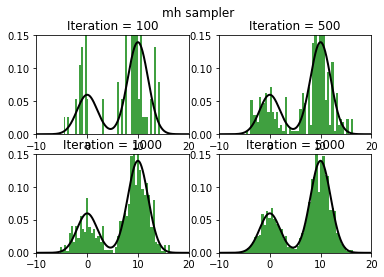

In [0]:
N = 5000                #  Number of iterations/samples.
sampler_name = 'mh'
begin = time.clock()
particles = mcmc(sampler_name,N)

print(particles)
print(time.clock()-begin)

plot_all(particles,221,N//50)
plot_all(particles,222,N//10)
plot_all(particles,223,N//5)
plot_all(particles,224,N)

pl.suptitle(sampler_name+' sampler')
pl.show()